# ECE 228 Project
## Tuberculosis Detection | Team 26
### Jianyu Tao
### Shreyas Borse
### Harshit Bhadani

In [20]:
%matplotlib inline

## Importing modules for necessary operations

import os
import shutil
import random
import torch
import torchvision
import numpy as np
import time
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import pdb
from PIL import Image
from matplotlib import pyplot as plt
import argparse
torch.manual_seed(0)

import torch.nn as nn
import torch.nn.functional as F

print('Using PyTorch version', torch.__version__)


from os.path import isfile
from os import rename
SMOOTH=1
import pdb
from sklearn.metrics import auc, roc_curve
from PIL.ImageFilter import GaussianBlur

# import pdb
from numpy import pi as PI
from numpy import sqrt
from scipy.special import comb
import math
import copy

Using PyTorch version 1.11.0


In [2]:
# Miscellaneous initialization
torch.manual_seed(1)
start_time = time.time()
parser = argparse.ArgumentParser()

In [3]:
train_dataset_path = ""
test_dataset_path = ""

In [4]:
root_dir = "/Users/harshitb/Desktop/Studies/ECE 228/TB_dataset/TB_Chest_Radiography_Database"
class_names = ['Normal', 'Tuberculosis']
source_dirs = ['Normal', 'Tuberculosis']

In [5]:
parser.add_argument('--num_epochs', type=int, default=5, help='Number of training epochs')
parser.add_argument('--batch_size', type=int, default=32, help='Batch size')
parser.add_argument('--lr', type=float, default=5e-4, help='Learning rate')
parser.add_argument('--l2', type=float, default=0, help='L2 regularisation')
parser.add_argument('--aug', action='store_true', default=False, help='Use data augmentation')
parser.add_argument('--data_path', type=str, default=root_dir,help='Path to data.')
parser.add_argument('--bond_dim', type=int, default=5, help='MPS Bond dimension')
parser.add_argument('--nChannel', type=int, default=1, help='Number of input channels')
parser.add_argument('--dense_net', action='store_true', default=False, help='Using Dense Net model')

args = parser.parse_args([])

In [6]:
batch_size = args.batch_size

# LoTeNet parameters
adaptive_mode = False 
periodic_bc   = False

kernel = 2 # Stride along spatial dimensions
output_dim = 1 # output dimension
 
feature_dim = 2

normTensor = 0.5*torch.ones(args.nChannel)
### Data processing and loading....


## Data Loading

In [7]:
### Data processing and loading....
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize(size=(256,256)),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=normTensor,std=normTensor)])

valid_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(256,256)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=normTensor,std=normTensor)
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

### Creating Datasets classes

In [8]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs,transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)}{class_name}')
            return images
        self.images={}
        self.class_names=['Normal', 'Tuberculosis']
        for c in self.class_names:
            self.images[c]=get_images(c)
        self.image_dirs=image_dirs
        self.transform=transform
        
    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    def __getitem__(self, index):
        class_name=random.choice(self.class_names)
        index=index%len(self.images[class_name])
        image_name=self.images[class_name][index]
        image_path =os.path.join(self.image_dirs[class_name], image_name)
        image=Image.open(image_path).convert('L')
        return self.transform(image), self.class_names.index(class_name)

In [9]:
train_dirs = {
    'Normal': root_dir + '/Normal',
    'Tuberculosis': root_dir + '/Tuberculosis'
}
dataset = ChestXRayDataset(train_dirs, train_transform)

Found 3500Normal
Found 700Tuberculosis


In [11]:
trainset, testset, valset = random_split(dataset, [3300, 600, 300])

In [12]:
train_loader =  torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

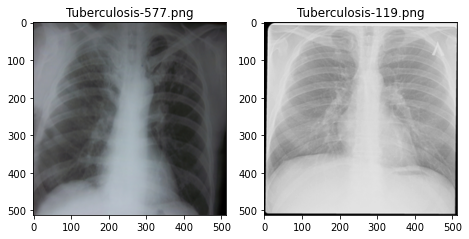

In [50]:
# sample images from dataset
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
test_folder=train_dirs['Normal']
for i in range(2):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img, cmap = 'gray')

# Creating various architectures

In [52]:
#Defining the convolutional neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #         xl = 1
        #         for i in x.shape[1:]: xl *= i
        #         self.fc1 = nn.Linear(13456, 120)
        self.fc1 = nn.Linear(984064, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        # -> n, 3, 32, 32
        #         x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        #         x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv1(x))  # -> n, 6, 14, 14
        x = F.relu(self.conv2(x))
        xl = 1
        for i in x.shape[1:]: xl *= i
        x = x.view(-1, xl)            # 
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 2
        return x

In [14]:
#Defining the LeNet neural network
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(59536, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [15]:
#Defining the VGG16 neural network
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32768, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 2)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
#         print("HERE ... ", x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [16]:
# Initialising variable that will be used in the experiments in the project

loss_data_of_model_epoch = {}
acc_of_model_epoch = {}
acc_of_model_batch = {}

all_models = {}
all_models['ConvNet'] = ConvNet()
all_models['LeNet5']  = LeNet5()
all_models['VGG16']   = VGG16()

for model_name in all_models.keys():
    loss_data_of_model_epoch[model_name] = {}
    acc_of_model_epoch[model_name] = {}
    acc_of_model_batch[model_name] = {}

LeNet5_model_with_epoch = {}

# Defining various functions to make the code modular

In [17]:
def get_acc_from_data(d_loader):
    """ A function to get the accuracy of the dataloader object passed as argument 
    """
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(2)]
        n_class_samples = [0 for i in range(2)]
        for images, labels in d_loader:
            #         print(len(labels))
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        
        all_acc = []
        overall_accuracy = acc
        all_acc.append(overall_accuracy)

        for i in range(2):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {class_names[i]}: {acc} %')
            all_acc.append(acc)
                
    #return all_acc
    return overall_accuracy
    

In [18]:

def train_by_model(model, model_name, epo = 3, verbose = True):
    """ A function to train the model passed
    """
    args.num_epochs = epo
    learning_rate = 0.001
    all_loss = []

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    n_total_steps = len(train_loader)
    for epoch in range(args.num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            all_loss.append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if ((i+1) % 10 == 0) and verbose:
                print (f'Epoch [{epoch+1}/{args.num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
        LeNet5_model_with_epoch[epoch+1] = copy.deepcopy(model)
        
    return all_loss

# Experiments

### Experiment: Deciding Architecture

In [22]:
# Checking various architectures above one by one with epoch = 3

model_name = "LeNet5"
model = all_models[model_name]

train_by_model(model, model_name)
get_acc_from_data(test_loader)

Epoch [1/3], Step [10/104], Loss: 0.1378
Epoch [1/3], Step [20/104], Loss: 0.0541
Epoch [1/3], Step [30/104], Loss: 0.1998
Epoch [1/3], Step [40/104], Loss: 0.0948
Epoch [1/3], Step [50/104], Loss: 0.2272
Epoch [1/3], Step [60/104], Loss: 0.0910
Epoch [1/3], Step [70/104], Loss: 0.1483
Epoch [1/3], Step [80/104], Loss: 0.1670
Epoch [1/3], Step [90/104], Loss: 0.0980
Epoch [1/3], Step [100/104], Loss: 0.1897
Epoch [2/3], Step [10/104], Loss: 0.0874
Epoch [2/3], Step [20/104], Loss: 0.0868
Epoch [2/3], Step [30/104], Loss: 0.1110
Epoch [2/3], Step [40/104], Loss: 0.1992
Epoch [2/3], Step [50/104], Loss: 0.0814
Epoch [2/3], Step [60/104], Loss: 0.3178
Epoch [2/3], Step [70/104], Loss: 0.0554
Epoch [2/3], Step [80/104], Loss: 0.0304
Epoch [2/3], Step [90/104], Loss: 0.1781
Epoch [2/3], Step [100/104], Loss: 0.0558
Epoch [3/3], Step [10/104], Loss: 0.1445
Epoch [3/3], Step [20/104], Loss: 0.0854
Epoch [3/3], Step [30/104], Loss: 0.0790
Epoch [3/3], Step [40/104], Loss: 0.0811
Epoch [3/3], S

97.0

### Experiment: Deciding epoch

Calculating accuracy of model with epoch:  1
Accuracy of the network: 87.0 %
Accuracy of Normal: 94.42508710801394 %
Accuracy of Tuberculosis: 80.19169329073482 %
Calculating accuracy of model with epoch:  2
Accuracy of the network: 92.16666666666667 %
Accuracy of Normal: 92.5925925925926 %
Accuracy of Tuberculosis: 91.74917491749174 %
Calculating accuracy of model with epoch:  3
Accuracy of the network: 92.66666666666667 %
Accuracy of Normal: 89.7196261682243 %
Accuracy of Tuberculosis: 96.05734767025089 %
Calculating accuracy of model with epoch:  4
Accuracy of the network: 93.66666666666667 %
Accuracy of Normal: 96.19047619047619 %
Accuracy of Tuberculosis: 90.87719298245614 %
Calculating accuracy of model with epoch:  5
Accuracy of the network: 95.33333333333333 %
Accuracy of Normal: 93.38235294117646 %
Accuracy of Tuberculosis: 96.95121951219512 %
Calculating accuracy of model with epoch:  6
Accuracy of the network: 94.83333333333333 %
Accuracy of Normal: 95.20547945205479 %
Accur

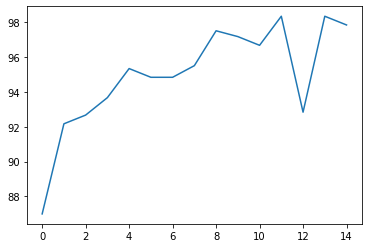

In [23]:
%%time
# Accuracy for LeNet5 with various epoch

model = LeNet5()
model_name = "LeNet5"

losses = train_by_model(model, model_name, 15, verbose = False)

accs = {}
for epo in LeNet5_model_with_epoch:
    print("Calculating accuracy of model with epoch: ", epo)
    model = LeNet5_model_with_epoch[epo]
    acc = get_acc_from_data(test_loader)
    accs[epo] = acc

acc_of_model_epoch[model_name] = accs

# -----------------------------------------------------
import json
with open('loss_data_of_model_epoch.json', 'w') as fp:
    json.dump(loss_data_of_model_epoch, fp)
    
with open('acc_of_model_epoch.json', 'w') as fp:
    json.dump(acc_of_model_epoch, fp)
# -----------------------------------------------------

model_name = "LeNet5"
max_acc_epo = 1
max_acc = acc_of_model_epoch[model_name][max_acc_epo]
for epo in acc_of_model_epoch[model_name]:
    if max_acc < acc_of_model_epoch[model_name][epo]:
        max_acc = acc_of_model_epoch[model_name][epo]
        max_acc_epo = epo

print("Maximum accuracy is ", max_acc, " with epoch as ", max_acc_epo)

plt.plot(list(accs.values()))

### Experiment: Deciding batch size

In [24]:
%%time

# Experiment with various batch sizes for LeNet5 with epoch = 5


for bs in [16, 32, 64]:
    print("Batch Size: ", bs)
    train_loader =  torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
    test_loader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=bs, shuffle=True)
    model = LeNet5()
    train_by_model(model, model_name, 5, verbose = False)
    acc_of_model_batch[model_name][bs] = get_acc_from_data(test_loader)

Batch Size:  16
Accuracy of the network: 96.16666666666667 %
Accuracy of Normal: 93.99293286219081 %
Accuracy of Tuberculosis: 98.10725552050474 %
Batch Size:  32
Accuracy of the network: 96.16666666666667 %
Accuracy of Normal: 95.65217391304348 %
Accuracy of Tuberculosis: 96.60493827160494 %
Batch Size:  64
Accuracy of the network: 94.33333333333333 %
Accuracy of Normal: 94.69964664310955 %
Accuracy of Tuberculosis: 94.00630914826499 %
CPU times: user 25min 32s, sys: 19.7 s, total: 25min 52s
Wall time: 21min 5s


In [27]:
# Getting Batch Size that gives highest accuracy

model_name = "LeNet5"
max_acc_bat = 16
max_acc = acc_of_model_batch[model_name][max_acc_bat]
for bat in acc_of_model_batch[model_name]:
    if max_acc < acc_of_model_batch[model_name][bat]:
        max_acc = acc_of_model_batch[model_name][bat]
        max_acc_bat = bat 

print("Maximum accuracy is ", max_acc, " with batch size as ", max_acc_bat)

print("Upon analyzing the runtime and accuracy of data we took the following parameters forward")
print("Batch Size: 32")
print("32 was taken as it had lesser runtime")

Maximum accuracy is  96.16666666666667  with epoch as  16
Upon analyzing the runtime and accuracy of data we took the following parameters forward
Batch Size: 32


# Conclusion

In [31]:
args.num_epochs = 12
batch_size = 32

train_loader =  torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

model = LeNet5()
model_name = "LeNet5"

losses = train_by_model(model, model_name, args.num_epochs)

Epoch [1/12], Step [10/104], Loss: 0.6191
Epoch [1/12], Step [20/104], Loss: 0.5606
Epoch [1/12], Step [30/104], Loss: 0.4078
Epoch [1/12], Step [40/104], Loss: 0.3709
Epoch [1/12], Step [50/104], Loss: 0.4473
Epoch [1/12], Step [60/104], Loss: 0.3545
Epoch [1/12], Step [70/104], Loss: 0.4041
Epoch [1/12], Step [80/104], Loss: 0.1900
Epoch [1/12], Step [90/104], Loss: 0.2357
Epoch [1/12], Step [100/104], Loss: 0.2593
Epoch [2/12], Step [10/104], Loss: 0.2958
Epoch [2/12], Step [20/104], Loss: 0.2190
Epoch [2/12], Step [30/104], Loss: 0.2317
Epoch [2/12], Step [40/104], Loss: 0.1674
Epoch [2/12], Step [50/104], Loss: 0.1525
Epoch [2/12], Step [60/104], Loss: 0.0860
Epoch [2/12], Step [70/104], Loss: 0.2359
Epoch [2/12], Step [80/104], Loss: 0.2206
Epoch [2/12], Step [90/104], Loss: 0.1535
Epoch [2/12], Step [100/104], Loss: 0.1222
Epoch [3/12], Step [10/104], Loss: 0.1029
Epoch [3/12], Step [20/104], Loss: 0.2905
Epoch [3/12], Step [30/104], Loss: 0.2315
Epoch [3/12], Step [40/104], Los

In [32]:
get_acc_from_data(test_loader)

Accuracy of the network: 98.0 %
Accuracy of Normal: 96.27118644067797 %
Accuracy of Tuberculosis: 99.67213114754098 %


98.0

In [33]:
get_acc_from_data(val_loader)

Accuracy of the network: 98.33333333333333 %
Accuracy of Normal: 97.5 %
Accuracy of Tuberculosis: 99.28571428571429 %


98.33333333333333